# Simulation

In this notebook, we will look at the application of random number generation to simulate physical processes and predict experimental results.

Monte Carlo methods are unsurprisingly well-suited to modelling processes that are inherently random, such as quantum mechanics.  They can also be used to model experimental uncertainty, as we shall see in a later notebook.

We will use particle decay an example of a random process. Consider an experiment in which a beam of unstable nuclei travel towards a detector, placed 12m from the origin of the beam. A given nucleus may decay before reaching the detector, emitting a photon. Depending on its direction of travel, the photon may hit the detector, where its position is registered.

We will build up a model of this experiment, and show how it can be used to inform the design of the experiment.

## Particle Decay

First, we model the decay position of the nuclei. The nuclei have a mean lifetime of $2.6 \times 10^{-3}$ s and are travelling at $1000 {\rm ms^{-1}}$

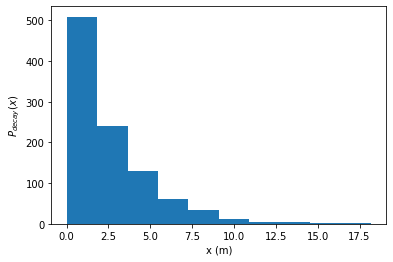

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# generate decay position from lifetime and velocity vector v
def decayPosition(tau, v):
    return np.random.exponential(tau)*v

v   = np.array([0., 0., 1e3])
tau = 2.6E-3  # s^-1

# generate a list of random positions using a "list comprehension"
ps  = np.array([decayPosition(tau, v) for _ in range(1000)])

# plot a histogram of decay positions
n, bins, patches = plt.hist(ps[:,2])
plt.ylabel(r"$P_{decay}(x)$")
plt.xlabel("x (m)")
plt.show()

## Decay Direction

Next we model the decay direction, which should be isotropic in the rest frame of the nucleus. This is the same as generating points on the surface of a unit sphere, with uniform probability over the solid angle $d\Omega$. This can be achieved in spherical coordinates, by generating the two angles, $\phi$ and $\theta$.  These should not be uniform, since the area element is given by :

$$d\Omega = \sin(\theta) d\phi d\theta$$

To obtain uniform probability over the sphere, we generate $\phi$ with a uniform distribution between $0$ and $2\pi$, and $\theta$ with a distribution proportional to $\sin \theta$.  This can be obtained using the transformation :
    $$\theta = \cos^{-1}(1-2 u) $$

Where u is uniformly distributed on the interval $[0,1)$. See the Random Distributions notebook for more details.

In [73]:
import math

# generate random isotropic unit vector
def decayDirection():
    # theta uniform between 0, pi
    theta = 2 * math.pi * np.random.random()

    # phi is NOT uniform
    phi = np.arccos(1 - 2*np.random.random())

    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    # return a 2D array (x/y/z on one axis, npoints on the other)
    return np.array([x,y,z])

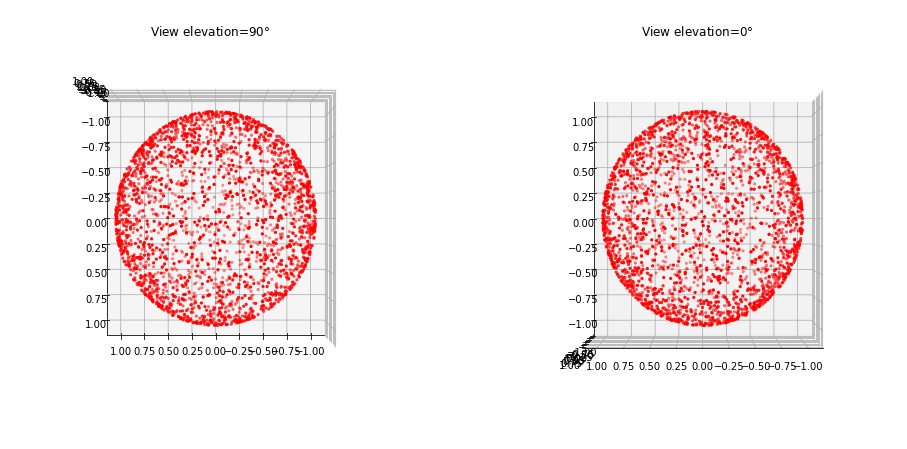

In [74]:
# generate 2500 points
ps  = np.array([decayDirection() for _ in range(2500)])

from mpl_toolkits.mplot3d import Axes3D

# plot viewed from above (elevtation = 90)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title(r"View elevation=90$\degree$")
ax1.scatter( ps[:,0], ps[:,1], ps[:,2], marker='.', c='r')
ax1.view_init(elev=90., azim=90)

# plot viewed from the side (elevation = 0)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title(r"View elevation=0$\degree$")
ax2.scatter( ps[:,0], ps[:,1], ps[:,2], marker='.', c='r')
ax2.view_init(elev=0., azim=90)

## Detector Hits

Now we can generate randomly distributed decay positions and directions, the next step is to compute the point where the photon hits the detector plane.  First we need a function that will find the intersection between a line (the photon path) and a plane (the detector).

In [75]:
# function to find the position of a hit
# based on intersection of a line with a plane
# the line is defined by point p0 and direction u
# the plane is defined by point p1 and normal n
def intersectLinePlane(p0, u, p1, n):

    w = p0 - p1
    s = -1 * np.dot(n, w) / np.dot(n, u) # distance from p0 to intersection
    
    # only return a non-zero hit if the photon is travelling towards the detector
    p_hit = np.array([0., 0., 0.])
    if s>0:
        p_hit = p0 + s*u

    return p_hit

##  Event Generation

Finally, a function to pull everything together: generate decay position, decay direction, and hit position.

In [43]:
# function to generate events, given parameters
# tau - nuclei mean lifetime
# v - nuclei velocity
# d - distance from beam origin to detector

def generateEvents(tau, d, v, nevt):
    
    d0 = np.array([0., 0., d])
    n  = np.array([0., 0., 1.])
    hits = []
    
    #print(hits)
    for i in range(nevt):
        
        # generate decay position
        p_decay = decayPosition(tau, v)
        
        # generate decay direction
        u_decay = decayDirection()
        
        # if decay happens before the detector, find the hit from photon path
        p_hit = np.array([0., 0., 0.])
        
        if np.linalg.norm(p_decay) < d:
            p_hit = intersectLinePlane(p_decay, u_decay, d0, n)
        
        # if the hit is in the detector plane, add it to the list of hits
        if p_hit[2]>0. and abs(p_hit[0])<10. and abs(p_hit[1])<10.:
            hits.append(p_hit)
        
    # return hits as a numpy array
    return np.array(hits)

Now we can generate a large sample of nuclei.

Note that I have done this in a separate cell, since it will take quite a long time to run.  Analysing the results is done in another cell, so that we can develop the analysis without having to re-generate all the events.  The plots shown below were generated with 1M events, the default here is 50k events, which will produce reasonably fast results, although the distributions are significantly more noisy.

In [ ]:
# test parameters
tau  = 2.6e-3 # s
d    = 12.    # m
v    = np.array([0., 0., 1e3])    # m s-1
nevt = 50000

hits = generateEvents(tau, d, v, nevt)

Fraction of nuclei producing a hit : 0.181588


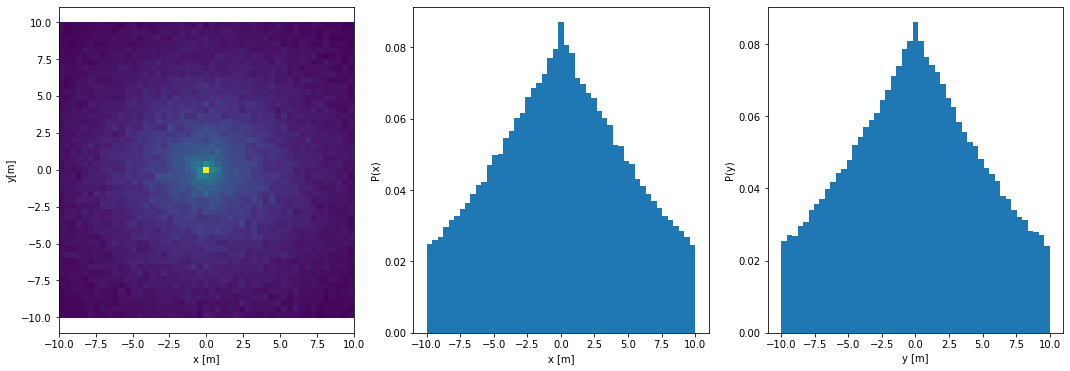

In [79]:
print("Fraction of nuclei producing a hit : {}".format(len(hits)/nevt))

# 2D histogram of hit positions from -10m to 10m in x,y directions
bins = np.linspace(-10, 10, 50)
fig=plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(131, xlabel='x [m]', ylabel='y[m]')
ax1.axis('equal')
h, xedges, yedges, quadmesh = ax1.hist2d(hits[:,0], hits[:,1], bins)

# 1D histogram of hit x
ax2 = fig.add_subplot(132, xlabel='x [m]', ylabel='P(x)')
ax2.hist(hits[:,0], bins, density=True)

# 1D histogram of hit y
ax3= fig.add_subplot(133, xlabel='y [m]', ylabel='P(y)')
ax3.hist(hits[:,1], bins, density=True)

plt.show()

Around 18% of nuclei decay and produce a photon that can be detected.  The photon hits form a peak around $(0,0)$ in the detector $(x,y)$ plane.

## Beam & Hit Smearing

The model used so far for the beam is quite simplistic.  More realistically, there will be some spread in both direction and total velocity. We can include this in our simulation by introducing an appropriate function to generate the beam velocity vector, here by generating Gaussian-distributed variation in each component of the vector.

In [59]:
# function to smear beam velocity in 3D
def beamSmear(v, ex, ey, ez):
    xx = np.random.normal(0., ex)
    yy = np.random.normal(0., ey)
    zz = np.random.normal(0., ez)
    return v + np.array([xx, yy, zz])

In addition to the physical processes modelled above, that result in a particle hitting the detector, we can also model effects in the detector itself.  For example, the detector may be noisy and we can add randomly generated hits to simulate this.  In the simple example below, we assume the detector can measure the position of hits to a particular _precision_ in $x,y$.  This can be modelled by adding normally distributed offsets to the $x,y$ position of the true hit.  This procedure is sometimes referred to as "smearing" the hit position. Note that the code to achieve this is extremely similar to that usde for modelling the beam velocity.

In [60]:
# function to smear hit position in 2D
def hitSmear(p, ex, ey):
    xx = np.random.normal(0., ex)
    yy = np.random.normal(0., ey)
    return p + np.array([xx, yy, 0.])

Having written our new smearing functions, we can update the function to generate events.

In [61]:
# function to generate events, given parameters
# tau - nuclei mean lifetime
# v - nuclei velocity
# d - distance from beam origin to detector
# vdx, vdy, vdz - std dev of velocity in each of 3 components
def generateEventsExt(tau, d, v0, vdx, vdy, vdz, ex, ey, nevt):

    d0 = np.array([0., 0., d])
    n  = np.array([0., 0., 1.])
    hits = []
    
    #print(hits)
    for i in range(nevt):
        
        # smear the beam direction
        v = beamSmear(v0, vdx, vdy, vdz)
        
        # generate decay position
        p_decay = decayPosition(tau, v)
        
        # generate decay direction
        u_decay = decayDirection()
        
        # if decay happens before the detector, find the hit from photon path
        p_hit = np.array([0., 0., 0.])
        
        if np.linalg.norm(p_decay) < d:
            p_hit = intersectLinePlane(p_decay, u_decay, d0, n)
        
        # if the hit is in the detector plane, add it to the list of hits
        if p_hit[2]>0. and abs(p_hit[0])<10. and abs(p_hit[1])<10.:
            p_meas = hitSmear(p_hit, ex, ey)
            hits.append(p_meas)

        # or find the hit from nucleus path if it doesn't
        #else:
        #    p_hit = intersectLinePlane(np.array([0,0,0]), v, d0, n)
        
    # return hits as a numpy array
    return np.array(hits)

Now we can run the simulation with different parameters to explore how they impact the resulting distribution

In [69]:
# test parameters
tau  = 2.6e-3 # s
d    = 12.    # m
v    = np.array([0., 0., 1e3])    # m s-1
nevt = 50000

vdx = 200.
vdy = 100.
vdz = 0.
ex  = 0.5
ey  = 4.0

# enable beam smearing only
hits2 = generateEventsExt(tau, d, v, vdx, vdy, vdz, 0., 0., nevt)

# enable det smearing only
hits3 = generateEventsExt(tau, d, v, 0., 0., 0., ex, ey, nevt)

# enable both beam and det smearing
hits4 = generateEventsExt(tau, d, v, vdx, vdy, vdz, ex, ey, nevt)

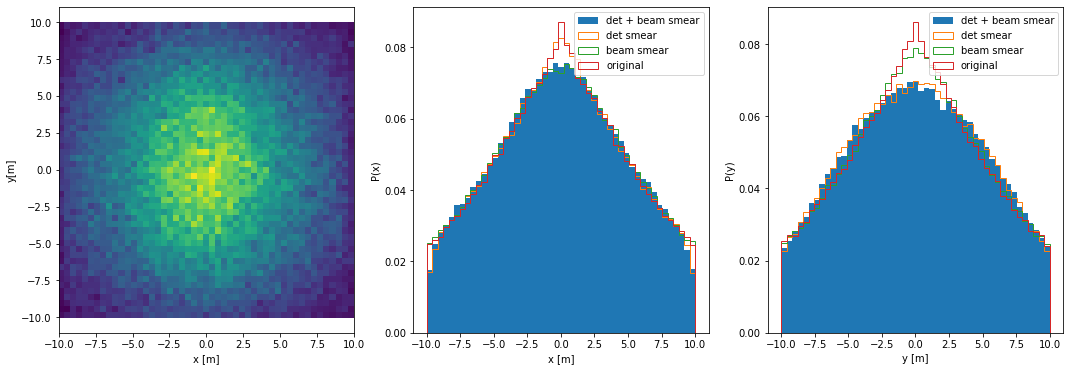

In [80]:
# 2D histogram of hit positions
bins = np.linspace(-10, 10, 50)
fig=plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(131, xlabel='x [m]', ylabel='y[m]')
ax1.axis('equal')
h, xedges, yedges, quadmesh = ax1.hist2d(hits4[:,0], hits4[:,1], bins)

# 1D histogram of hit x
ax2 = fig.add_subplot(132, xlabel='x [m]', ylabel='P(x)')
ax2.hist(hits4[:,0], bins, label='det + beam smear', density=True)
ax2.hist(hits3[:,0], bins, histtype='step', label='det smear', density=True)
ax2.hist(hits2[:,0], bins, histtype='step', label='beam smear', density=True)
ax2.hist(hits[:,0], bins, histtype='step', label='original', density=True)  # original distribution for reference
#ax2.set_yscale('log')
ax2.legend()

# 1D histogram of hit y
ax3= fig.add_subplot(133, xlabel='y [m]', ylabel='P(y)')
ax3.hist(hits4[:,1], bins, label='det + beam smear', density=True)
ax3.hist(hits3[:,1], bins, histtype='step', label='det smear', density=True)
ax3.hist(hits2[:,1], bins, histtype='step', label='beam smear', density=True)
ax3.hist(hits[:,1], bins, histtype='step', label='original', density=True)  # original distribution for reference
#ax3.set_yscale('log')
ax3.legend()

plt.show()

Comparing distributions with detector smearing and beam smearing applied individually and separately, we can see the impact of each effect on the ultimate distribution.  The effects are quite subtle, but this is frequently the case in situations where Monte Carlo simulations are useful.

You can use the simulation to investigate the impact of different parameters on the final distributions, simply changing the distrbutions and re-generating events.